In [20]:
import dolphindb as ddb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def draw(result):
    fig, axs = plt.subplots(4, figsize=(10, 10))
    result.set_index("trade_time").groupby('grp')['af_rev'].plot(legend=True, ax=axs[0])
    result.set_index("trade_time").groupby('grp')['cumret'].plot(legend=True, ax=axs[1])
    result.set_index("trade_time").groupby('grp')['cumfee'].plot(legend=True, ax=axs[2])
    result.set_index("trade_time").groupby('grp')['cnt'].plot(legend=True, ax=axs[3])
    
def cal_sharpe(ret: pd.Series):
    single_ret = ret.diff().dropna()
    sharpe = single_ret.mean() / single_ret.std() * np.sqrt(365*3)
    return sharpe

def backtest(factor, num = 2):
    def core(num):
        sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
        sess.run("factor = table(1000:0,`trade_time`instrument`factor_value, [TIMESTAMP,SYMBOL,DOUBLE])")
        sess.run("tableInsert{factor}",factor.dropna())
        # sess.upload({
        #     'factor': factor,
        #     'num': num
        # })
        sess.upload({'num': num})
        try:
            df: pd.DataFrame = sess.runFile("backtest.dos")
        except Exception as e:
            error_msg = str(e).split('script:')[0]
            print(error_msg)
            raise e
        sess.run('clearAllCache()')
        sess.close()
        return df
    
    df = core(num)    
    return df

                 trade_time instrument  factor_value
338872  2021-01-01 00:00:00  1INCHUSDT      0.012227
338873  2021-01-01 00:00:00   AAVEUSDT      0.011502
338874  2021-01-01 00:00:00    ADAUSDT     -0.001980
338875  2021-01-01 00:00:00   ALGOUSDT     -0.007591
338876  2021-01-01 00:00:00  ALPHAUSDT      0.006095
...                     ...        ...           ...
4556433 2024-02-24 11:00:00    ZECUSDT     -0.004093
4556434 2024-02-24 11:00:00    ZENUSDT     -0.003406
4556435 2024-02-24 11:00:00   ZETAUSDT     -0.002366
4556436 2024-02-24 11:00:00    ZILUSDT     -0.007042
4556437 2024-02-24 11:00:00    ZRXUSDT     -0.009150

[4217566 rows x 3 columns]
2.7508478757373904


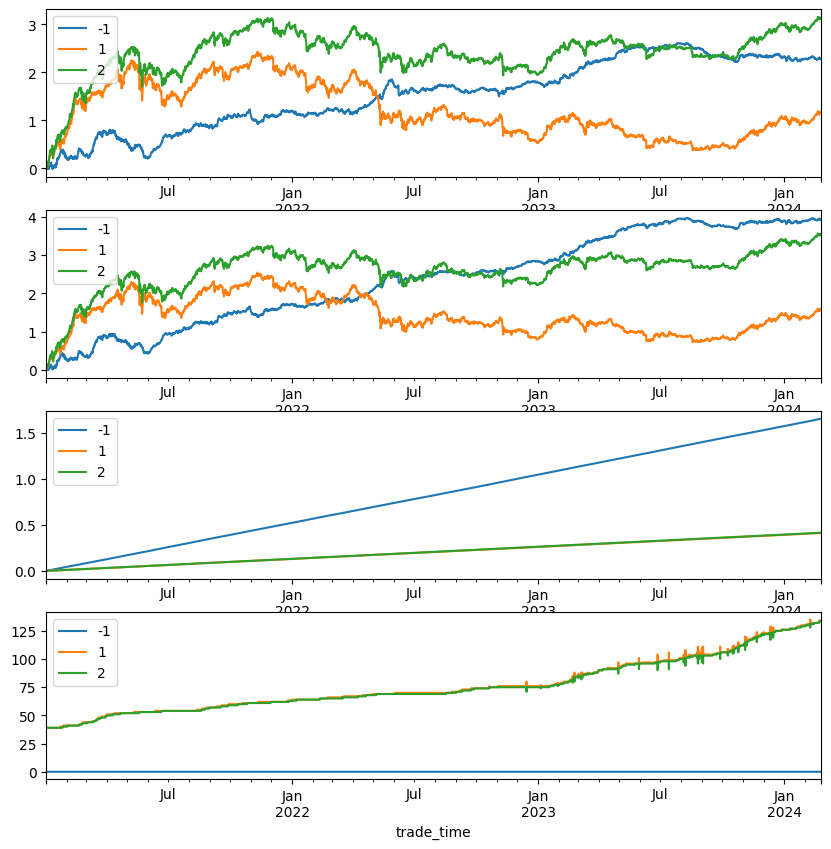

In [10]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
df = sess.runFile('factors/factor1.dos')
df = df[df['trade_time'] >= '20210101']
print(df)
# df['factor_value'] = -df['factor_value']
# print(df)
sess.close()
result = backtest(df, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

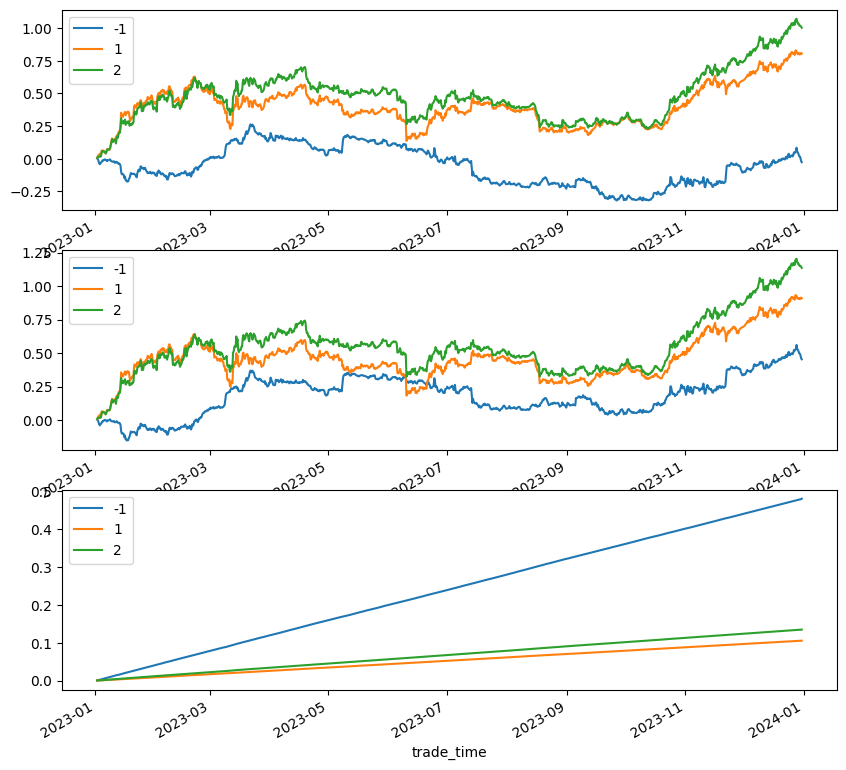

In [186]:
draw(result)

In [11]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour") order by trade_time, instrument
    ''')
for i in range(1, 102):
    try:
        df = sess.run(f'''
            factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
            factor = table(factor.rowNames() as trade_time, factor)
            factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
            factor.rename!(`trade_time`instrument`factor_value)
            factor = select trade_time, instrument, factor_value from factor where factor_value is not null
            select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
        ''')
        print(df)
        result = backtest(df, 2)
        sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
        if abs(sharpe) > 1:
            with open('dynamic_2_grp_2.txt', 'a') as f:
                f.write(f'{i},{sharpe}\n')
        print(sharpe)
    except:
        print("skip ", i)
sess.close()

        trade_time     instrument  factor_value
0       2021-01-01   1000BONKUSDT     -0.496032
1       2021-01-01  1000FLOKIUSDT     -0.496032
2       2021-01-01   1000LUNCUSDT     -0.496032
3       2021-01-01   1000PEPEUSDT     -0.496032
4       2021-01-01   1000RATSUSDT     -0.496032
...            ...            ...           ...
6622807 2024-01-01        YGGUSDT     -0.384921
6622808 2024-01-01        ZECUSDT     -0.202381
6622809 2024-01-01        ZENUSDT      0.019841
6622810 2024-01-01        ZILUSDT      0.019841
6622811 2024-01-01        ZRXUSDT      0.019841

[6622812 rows x 3 columns]
Server response: 'backtest(factor, num) => backtest: grouped = group_factor(combine, num) => group_factor: throw "group ratio > 20%, check!", quantile_ratio => trade_time              grp ratio             ----------------------- --- ----------------- 2021.01.01T08:00:00.000 1   1                 2021.01.02T00:00:00.000 1   0.435897435897436 2021.01.02T00:00:00.000 2   0.435897435897436 2021.0

trade_time              instrument factor_value      
----------------------- ---------- ------------------
2021.01.01T01:00:00.000 1INCHUSDT  1.025641025641025 
2021.01.01T01:00:00.000 AAVEUSDT   -1.730769230769231
2021.01.01T01:00:00.000 ADAUSDT    1.846153846153846 
2021.01.01T01:00:00.000 ALGOUSDT   1.58974358974359  
2021.01.01T01:00:00.000 ALPHAUSDT  1.256410256410256 
2021.01.01T01:00:00.000 ATOMUSDT   -1.91025641025641 
2021.01.01T01:00:00.000 AVAXUSDT   1.435897435897436 
2021.01.01T01:00:00.000 AXSUSDT    1.179487179487179 
2021.01.01T01:00:00.000 BALUSDT    1.717948717948718 
2021.01.01T01:00:00.000 BANDUSDT   1.282051282051282 
2021.01.01T01:00:00.000 BATUSDT    1.346153846153846 
2021.01.01T01:00:00.000 BCHUSDT    1.628205128205128 
2021.01.01T01:00:00.000 BELUSDT    1.153846153846154 
2021.01.01T01:00:00.000 BLZUSDT    1.474358974358974 
2021.01.01T01:00:00.000 BNBUSDT    1.82051282051282  
2021.01.01T01:00:00.000 BTCUSDT    1.884615384615385 
2021.01.01T01:00:00.000 COMP

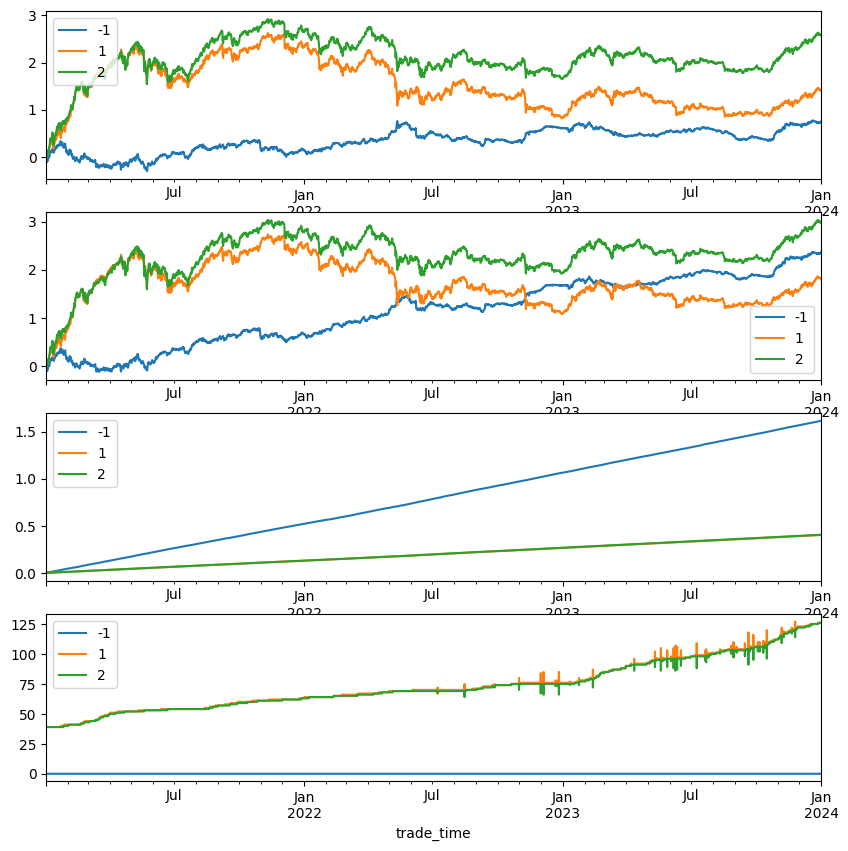

In [21]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour") order by trade_time, instrument
    ''')

i = 19
df = sess.run(f'''
    factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
    factor = table(factor.rowNames() as trade_time, factor)
    factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
    factor.rename!(`trade_time`instrument`factor_value)
    factor = select trade_time, instrument, factor_value from factor where factor_value is not null
    select * from factor where trade_time >= 2021.01.01 00:00:00.000 order by trade_time, instrument
''')
# df['factor_value'] = -df['factor_value']
sess.close()
# df = df[df['trade_time'] >= '20200201']
# print(df)
result = backtest(df, 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [24]:
sess = ddb.session(host='localhost', port=8848, userid='admin', password='123456')
sess.runFile('factors/alpha101.dos')
sess.run('''
    instruments = select trade_time as tradetime, instrument as securityid, open, high, low, close, volume as vol from loadTable("dfs://crypto_db", "k_hour")
    ''')
lucky = '''2,1.4317617658091235
6,-1.22331333141334
19,1.7492571361873892
30,1.5846507522690674
37,1.0444579127639086
38,2.2345266919595885
54,1.3956501862195263
60,1.0714170696945486'''
tot = None
for line in lucky.split('\n'):
    parts = line.split(',')
    i = parts[0]
    weight = float(parts[1])
    df: pd.DataFrame = sess.run(f'''
        factor = calAlpha{i}(instruments, 2020.12.01 00:00:00.000, 2024.01.01 00:00:00.000)
        factor = table(factor.rowNames() as trade_time, factor)
        factor = factor.unpivot(`trade_time, factor.columnNames()[1:])
        factor.rename!(`trade_time`instrument`factor_value)
        factor = select timestamp(trade_time) as trade_time, instrument, zscore(factor_value) as factor_value from factor where factor_value is not null
        factor = select trade_time, instrument, factor_value / max(abs(factor_value)) as factor_value from factor context by trade_time
        select * from factor where trade_time >= 2021.01.01 order by trade_time, instrument
    ''')
    df['factor_value'] = df['factor_value'] * weight
    if tot is not None:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = pd.merge(tot, df, how='left', on=['trade_time', 'instrument'])
    else:
        df = df.rename(columns={'factor_value': f'factor_value_{i}'})
        tot = df
print(tot)
# print(df)
# result = backtest(df, 2)
# sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
# print(sharpe)
# draw(result)

sess.close()

        trade_time instrument  factor_value_2  factor_value_6  \
0       2021-01-01  1INCHUSDT       -0.778824        0.916318   
1       2021-01-01   AAVEUSDT       -0.517991        0.623567   
2       2021-01-01    ADAUSDT       -0.177596       -0.108064   
3       2021-01-01   ALGOUSDT        0.204960       -0.584488   
4       2021-01-01  ALPHAUSDT       -0.128489        0.005631   
...            ...        ...             ...             ...   
3801186 2024-01-01    YGGUSDT       -0.669524       -0.822685   
3801187 2024-01-01    ZECUSDT       -0.332051       -0.451507   
3801188 2024-01-01    ZENUSDT        0.463391        0.148614   
3801189 2024-01-01    ZILUSDT       -0.128856        0.639151   
3801190 2024-01-01    ZRXUSDT       -0.176091       -0.233173   

         factor_value_19  factor_value_30  factor_value_37  factor_value_38  \
0               0.914280         0.201676         0.842937         0.689298   
1              -1.511668         0.728605        -0.020722   

In [38]:
# df = tot[tot.isna()]
df = tot.fillna(0)
df
# tot[tot['factor_value_19'].isna()]

,trade_time,instrument,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60
0,2021-01-01,1INCHUSDT,-0.778824,0.916318,0.914280,0.201676,0.842937,0.689298,1.395650,0.392795
1,2021-01-01,AAVEUSDT,-0.517991,0.623567,-1.511668,0.728605,-0.020722,0.523060,0.970218,-0.332587
2,2021-01-01,ADAUSDT,-0.177596,-0.108064,1.636422,-0.176887,0.152010,-0.277247,0.499051,0.471897
3,2021-01-01,ALGOUSDT,0.204960,-0.584488,1.399469,-0.129086,-0.308608,-1.141374,-0.124158,-0.720237
4,2021-01-01,ALPHAUSDT,-0.128489,0.005631,1.162516,0.459433,-0.251031,0.408804,0.917999,0.214290
...,...,...,...,...,...,...,...,...,...,...
3801186,2024-01-01,YGGUSDT,-0.669524,-0.822685,1.459051,0.095517,-0.097938,0.253748,-0.736221,-0.065684
3801187,2024-01-01,ZECUSDT,-0.332051,-0.451507,0.971920,-0.044190,-0.321095,0.568645,-0.065588,0.627625
3801188,2024-01-01,ZENUSDT,0.463391,0.148614,1.047926,0.078934,-0.336345,-0.701410,-0.433009,0.091231
3801189,2024-01-01,ZILUSDT,-0.128856,0.639151,-1.370456,0.022905,0.080245,-1.039420,-0.439598,0.083064


1.6354123002661525


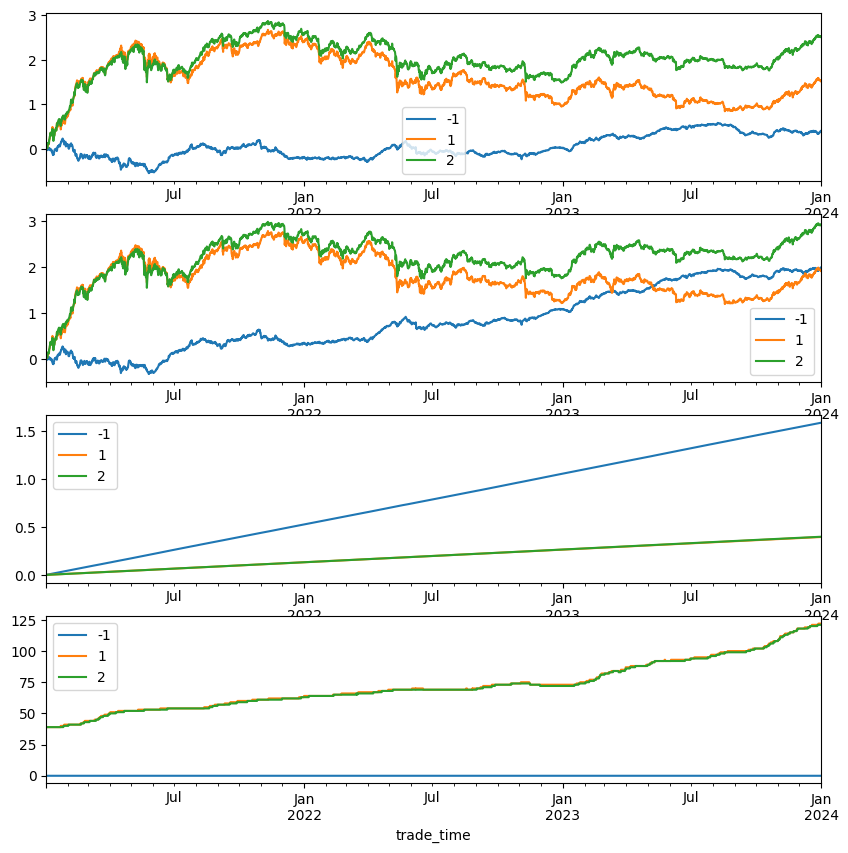

In [27]:
df['factor_value'] = df.iloc[:, 2:].sum(axis=1)
result = backtest(df[['trade_time', 'instrument', 'factor_value']], 2)
sharpe = cal_sharpe(result[result['grp']==-1]['cumret'])
print(sharpe)
draw(result)

In [39]:
df

,trade_time,instrument,factor_value_2,factor_value_6,factor_value_19,factor_value_30,factor_value_37,factor_value_38,factor_value_54,factor_value_60
0,2021-01-01,1INCHUSDT,-0.778824,0.916318,0.914280,0.201676,0.842937,0.689298,1.395650,0.392795
1,2021-01-01,AAVEUSDT,-0.517991,0.623567,-1.511668,0.728605,-0.020722,0.523060,0.970218,-0.332587
2,2021-01-01,ADAUSDT,-0.177596,-0.108064,1.636422,-0.176887,0.152010,-0.277247,0.499051,0.471897
3,2021-01-01,ALGOUSDT,0.204960,-0.584488,1.399469,-0.129086,-0.308608,-1.141374,-0.124158,-0.720237
4,2021-01-01,ALPHAUSDT,-0.128489,0.005631,1.162516,0.459433,-0.251031,0.408804,0.917999,0.214290
...,...,...,...,...,...,...,...,...,...,...
3801186,2024-01-01,YGGUSDT,-0.669524,-0.822685,1.459051,0.095517,-0.097938,0.253748,-0.736221,-0.065684
3801187,2024-01-01,ZECUSDT,-0.332051,-0.451507,0.971920,-0.044190,-0.321095,0.568645,-0.065588,0.627625
3801188,2024-01-01,ZENUSDT,0.463391,0.148614,1.047926,0.078934,-0.336345,-0.701410,-0.433009,0.091231
3801189,2024-01-01,ZILUSDT,-0.128856,0.639151,-1.370456,0.022905,0.080245,-1.039420,-0.439598,0.083064
